In [9]:
import numpy as np
from scipy.ndimage import sobel
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

In [10]:
def sobel_filter(image):
    """
    اعمال فیلتر Sobel بر روی تصویر با استفاده از کانولوشن.
    """
    # تبدیل تصویر به مقیاس خاکستری (اگر تصویر رنگی باشد)
    if len(image.shape) == 3:  # اگر تصویر رنگی باشد
        image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # تبدیل به تصویر خاکستری

    # تعریف فیلترهای Sobel برای جهت x و y
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    # اعمال کانولوشن با فیلتر Sobel
    gradient_x = convolve2d(image, sobel_x, mode='same', boundary='symm')
    gradient_y = convolve2d(image, sobel_y, mode='same', boundary='symm')

    # محاسبه انرژی یال‌ها (جمع مربعات گرادیان‌ها)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # نرمال کردن انرژی برای نمایش به عنوان تصویر
    gradient_magnitude = gradient_magnitude / gradient_magnitude.max() * 255

    return gradient_magnitude.astype(np.uint8)

In [11]:
img = plt.imread('cameraman.jpg')

In [12]:
energy = sobel_filter(img)

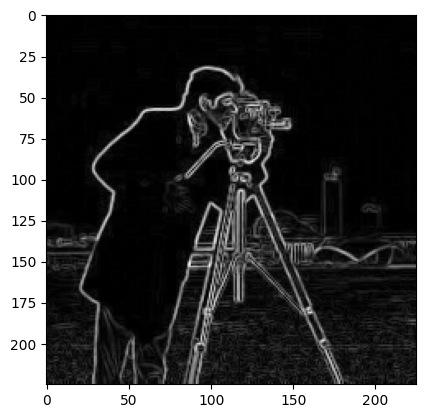

In [13]:
plt.imshow(energy, 'gray')
plt.show()

In [14]:
def find_vertical_seam(energy):
    """
    پیدا کردن seam عمودی با حداقل انرژی با استفاده از برنامه‌ریزی پویا.
    """
    rows, cols = energy.shape
    dp = energy.copy()

    # ساخت ماتریس DP
    for i in range(1, rows):
        for j in range(cols):
            # حداقل انرژی برای رسیدن به پیکسل (i, j)
            if j == 0:
                dp[i][j] += min(dp[i-1][j], dp[i-1][j+1])
            elif j == cols - 1:
                dp[i][j] += min(dp[i-1][j-1], dp[i-1][j])
            else:
                dp[i][j] += min(dp[i-1][j-1], dp[i-1][j], dp[i-1][j+1])
                  # پیدا کردن seam با ردیابی معکوس
    seam = []
    last_row = rows - 1
    j = np.argmin(dp[last_row])  # پیکسل با کمترین انرژی در سطر آخر
    seam.append((last_row, j))

    for i in range(last_row - 1, -1, -1):
        if j == 0:
            j_next = np.argmin([dp[i][j], dp[i][j+1]])
        elif j == cols - 1:
            j_next = np.argmin([dp[i][j-1], dp[i][j]]) + (j - 1)
        else:
            j_next = np.argmin([dp[i][j-1], dp[i][j], dp[i][j+1]]) + (j - 1)
        j = j_next
        seam.append((i, j))

    seam.reverse()
    return seam

In [16]:
seam = find_vertical_seam(energy)

C:\Users\Dr.Latif\AppData\Local\Temp\ipykernel_18792\4102159387.py:17: RuntimeWarning: overflow encountered in scalar add
  dp[i][j] += min(dp[i-1][j-1], dp[i-1][j], dp[i-1][j+1])
C:\Users\Dr.Latif\AppData\Local\Temp\ipykernel_18792\4102159387.py:13: RuntimeWarning: overflow encountered in scalar add
  dp[i][j] += min(dp[i-1][j], dp[i-1][j+1])
C:\Users\Dr.Latif\AppData\Local\Temp\ipykernel_18792\4102159387.py:15: RuntimeWarning: overflow encountered in scalar add
  dp[i][j] += min(dp[i-1][j-1], dp[i-1][j])


In [17]:
seam

[(0, np.int64(174)),
 (1, np.int64(174)),
 (2, np.int64(174)),
 (3, np.int64(174)),
 (4, np.int64(174)),
 (5, np.int64(174)),
 (6, np.int64(174)),
 (7, np.int64(175)),
 (8, np.int64(176)),
 (9, np.int64(177)),
 (10, np.int64(177)),
 (11, np.int64(177)),
 (12, np.int64(177)),
 (13, np.int64(178)),
 (14, np.int64(179)),
 (15, np.int64(180)),
 (16, np.int64(179)),
 (17, np.int64(179)),
 (18, np.int64(179)),
 (19, np.int64(179)),
 (20, np.int64(179)),
 (21, np.int64(179)),
 (22, np.int64(179)),
 (23, np.int64(179)),
 (24, np.int64(179)),
 (25, np.int64(179)),
 (26, np.int64(179)),
 (27, np.int64(179)),
 (28, np.int64(179)),
 (29, np.int64(179)),
 (30, np.int64(179)),
 (31, np.int64(179)),
 (32, np.int64(179)),
 (33, np.int64(179)),
 (34, np.int64(179)),
 (35, np.int64(179)),
 (36, np.int64(179)),
 (37, np.int64(178)),
 (38, np.int64(177)),
 (39, np.int64(176)),
 (40, np.int64(175)),
 (41, np.int64(174)),
 (42, np.int64(174)),
 (43, np.int64(173)),
 (44, np.int64(172)),
 (45, np.int64(172))

In [18]:
def remove_seam(image, seam):
    """
    حذف یک seam از تصویر.
    """
    rows, cols, channels = image.shape
    new_image = np.zeros((rows, cols-1, channels), dtype=image.dtype)

    for i, j in seam:
        new_image[i] = np.delete(image[i], j, axis=0)

    return new_image

In [19]:
def resize_image(image, target_width):
    """
    تغییر اندازه تصویر با استفاده از Seam Carving.
    """
    current_width = image.shape[1]
    while current_width > target_width:
        # محاسبه انرژی و پیدا کردن seam
        energy = calculate_energy(image)
        seam = find_vertical_seam(energy)

        # حذف seam
        image = remove_seam(image, seam)
        current_width -= 1

    return image

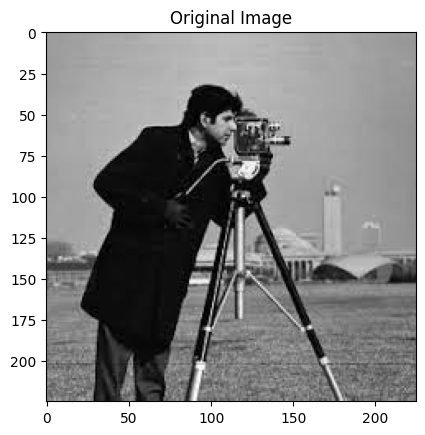

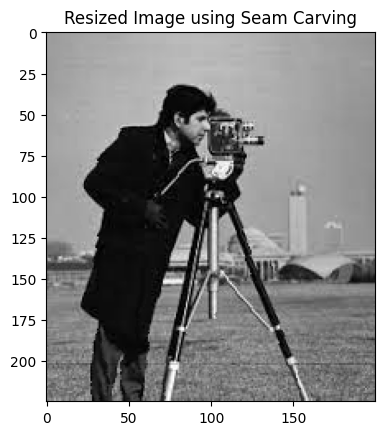

In [22]:
image = plt.imread("cameraman.jpg")  # جایگزین "example.jpg" با مسیر تصویر مورد نظر خود

# نمایش تصویر اصلی
plt.imshow(image)
plt.title("Original Image")
plt.show()

# تنظیم عرض نهایی تصویر
target_width = 200  # عرض مورد نظر

# تغییر اندازه تصویر با Seam Carving
resized_image = resize_image(image, target_width)

# نمایش تصویر تغییر اندازه شده
plt.imshow(resized_image)
plt.title("Resized Image using Seam Carving")
plt.show()